##Set Up

In [1]:
import pandas as pd
import numpy as np
import json
import os
import shutil #save images
from tqdm import tqdm #progress bar
import cv2
import matplotlib.pyplot as plt

from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

In [4]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  13851      0 --:--:-- --:--:-- --:--:-- 13848
OK
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 n

In [5]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"
downsampled_path = f"{local_path}/raw-data/downsampled-data"
preprocessed_path = f"{local_path}/raw-data/preprocessed_data"
preprocessed_red_path = f"{local_path}/raw-data/preprocessed_data_red"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1721126230,"nanos":136132445},"severity":"INFO","message":"Start gcsfuse/2.3.1 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1721126230,"nanos":136350818},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier

In [6]:
#check mounting
os.listdir(f"{local_path}/raw-data/")

['downsampled-data',
 'orinoquia-camera-traps',
 'preprocessed_data',
 'preprocessed_data_red']

##Sample Image Per Class

In [7]:
#check number of images: 31836
imageFilenames = pd.DataFrame(os.listdir(preprocessed_path), columns=['filename_new'])
imageFilenames['filename'] = imageFilenames['filename_new'].str.split('_').str[0]+'/'+imageFilenames['filename_new'].str.split('_').str[2]
numImage = len(imageFilenames)
print("Number of Images: ", numImage)
imageFilenames.head(5)

Number of Images:  31836


,filename_new,filename
0,A06_100EK113_01130049.JPG,A06/01130049.JPG
1,A06_100EK113_01130050.JPG,A06/01130050.JPG
2,A06_100EK113_01130051.JPG,A06/01130051.JPG
3,A06_100EK113_01130052.JPG,A06/01130052.JPG
4,A06_100EK113_01130053.JPG,A06/01130053.JPG


In [8]:
#check data class distribution
imageLabels = pd.read_csv("/content/drive/MyDrive/w281_Project/0_data/sample_images/images_labels.csv")
imageLabels.head(5)

,filename,timestamp,image_id,common_name,sp_num
0,N25/03310082.JPG,2020-03-31T14:28:14Z,902b671f-58b9-4cb0-9898-bd53c9909e51,Collared Peccary,1
1,N29/03310288.JPG,2020-03-31T06:49:17Z,e727dc42-5ebb-46a0-a979-eac158c050e6,Collared Peccary,1
2,A06/06020479.JPG,2020-06-02T08:12:17Z,db3c3213-5ad9-4bf7-94a8-92ded5efb5a5,Black Agouti,1
3,A02/03100387.JPG,2020-03-10T06:58:27Z,c7e33138-08ac-461d-a267-ba44a2f123ad,Unknown species,1
4,A04/04180034.JPG,2020-04-18T05:37:56Z,52f77e0c-7023-4087-8414-26848579d14f,Bos Species,1


In [9]:
#join for labels
df = imageFilenames.merge(imageLabels, on='filename', how='left')
df.head(5)

,filename_new,filename,timestamp,image_id,common_name,sp_num
0,A06_100EK113_01130049.JPG,A06/01130049.JPG,2020-01-13T19:34:24Z,082a4f9f-4888-478f-8db1-dc49530fd898,Dasypus Species,1
1,A06_100EK113_01130050.JPG,A06/01130050.JPG,2020-01-13T19:34:25Z,cdf8eb07-2165-477c-821b-b831bb937b93,Dasypus Species,1
2,A06_100EK113_01130051.JPG,A06/01130051.JPG,2020-01-13T19:34:26Z,d91e29f5-0787-435f-a7f2-e7adeaf09773,Dasypus Species,1
3,A06_100EK113_01130052.JPG,A06/01130052.JPG,2020-01-13T19:34:28Z,ad260c3b-530e-40d5-8ca0-4fd78276413e,Dasypus Species,1
4,A06_100EK113_01130053.JPG,A06/01130053.JPG,2020-01-13T19:34:29Z,d4fe1eaf-858c-406f-ae23-4c3973c41664,Dasypus Species,1


# Eunice's Checking Begin

In [22]:
preprocessed_path = f"{local_path}/raw-data/preprocessed_data"
preprocessed_img = os.listdir(preprocessed_path)
len(preprocessed_img)

31836

In [26]:
# There are more rows than imageFilenames after joining
# suspecting multiple labels
len(df) - len(imageFilenames)

30

In [19]:
print('Distribution of species\n', df['common_name'].value_counts())
print('Total number of filename merged', len(df))

Distribution of species
 common_name
Collared Peccary        15852
Black Agouti             6768
Spotted Paca             2627
White-lipped Peccary     1974
Dasypus Species          1673
South American Coati     1154
Domestic Horse            927
Bos Species               880
Crestless Curassow          6
Spix's Guan                 5
Name: count, dtype: int64
Total number of filename merged 31866


In [27]:
df_birdies = df[df['common_name'].isin(['Crestless Curassow', 'Spix\'s Guan'])]
df_birdies.head()

In [31]:
# Check for duplications in left and right dataframes
df_dual_class = df[df['image_id'].isin(df_birdies['image_id'])]

df_dual_class

,filename_new,filename,timestamp,image_id,common_name,sp_num,_merge
17395,N14_101EK113_04020211.JPG,N14/04020211.JPG,2020-04-02T08:27:59Z,0ccad3bd-12e2-4b71-b2f6-1adcf2ab16c0,Spix's Guan,2,both
17396,N14_101EK113_04020211.JPG,N14/04020211.JPG,2020-04-02T08:27:59Z,0ccad3bd-12e2-4b71-b2f6-1adcf2ab16c0,Black Agouti,2,both
17397,N14_101EK113_04020212.JPG,N14/04020212.JPG,2020-04-02T08:28:00Z,78ccde1e-94ad-43ef-a07b-9b79dd8d8a38,Spix's Guan,2,both
17398,N14_101EK113_04020212.JPG,N14/04020212.JPG,2020-04-02T08:28:00Z,78ccde1e-94ad-43ef-a07b-9b79dd8d8a38,Black Agouti,2,both
17399,N14_101EK113_04020213.JPG,N14/04020213.JPG,2020-04-02T08:28:01Z,1e0e482b-491d-4c13-995f-855e154d1982,Spix's Guan,2,both
17400,N14_101EK113_04020213.JPG,N14/04020213.JPG,2020-04-02T08:28:01Z,1e0e482b-491d-4c13-995f-855e154d1982,Black Agouti,2,both
17401,N14_101EK113_04020214.JPG,N14/04020214.JPG,2020-04-02T08:30:21Z,b2a7bc4d-fe10-426a-818a-d15a7304369a,Spix's Guan,2,both
17402,N14_101EK113_04020214.JPG,N14/04020214.JPG,2020-04-02T08:30:21Z,b2a7bc4d-fe10-426a-818a-d15a7304369a,Black Agouti,2,both
17403,N14_101EK113_04020215.JPG,N14/04020215.JPG,2020-04-02T08:30:22Z,45a8dd0e-8720-458e-83a1-0660915f1d8e,Black Agouti,2,both
17404,N14_101EK113_04020215.JPG,N14/04020215.JPG,2020-04-02T08:30:22Z,45a8dd0e-8720-458e-83a1-0660915f1d8e,Spix's Guan,2,both


In [37]:
# save birdies + Black Agouti images to 0_data/dual_class_images.csv
dual_class_csv = "/content/drive/MyDrive/w281_Project/0_data/dual_class_images.csv"

df_dual_class.to_csv(dual_class_csv, mode='a', header=False)

In [38]:
df = pd.read_csv(dual_class_csv)
df['common_name'].value_counts()

common_name
Domestic Horse        19
Bos Species           19
Black Agouti          11
Crestless Curassow     6
Spix's Guan            5
Name: count, dtype: int64

filename	timestamp	image_id	common_name	sp_num	camera	image_number

# Eunice's Checking End

In [ ]:
#select image sample per class

species_list = ['Collared Peccary',
                'Black Agouti',
                'Spotted Paca',
                'White-lipped Peccary',
                'Dasypus Species',
                'South American Coati',
                'Domestic Horse',
                'Bos Species',
                'Crestless Curassow',
                "Spix's Guan"]

sample_filenames = []

for item in species_list:
  sample_filenames.append(df[df['common_name']==item].sample()['filename_new'].values[0])

In [ ]:
sample_filenames

['N29_106EK113_04160313.JPG',
 'N25_104EK113_07060138.JPG',
 'N29_101EK113_01270077.JPG',
 'M04_106EK113_03260050.JPG',
 'A06_101EK113_05160059.JPG',
 'N27_100EK113_02070756.JPG',
 'A07_101EK113_05090085.JPG',
 'A07_102EK113_06220067.JPG',
 'N27_102EK113_06280814.JPG',
 'N14_101EK113_04020215.JPG']

##Feature - HOG

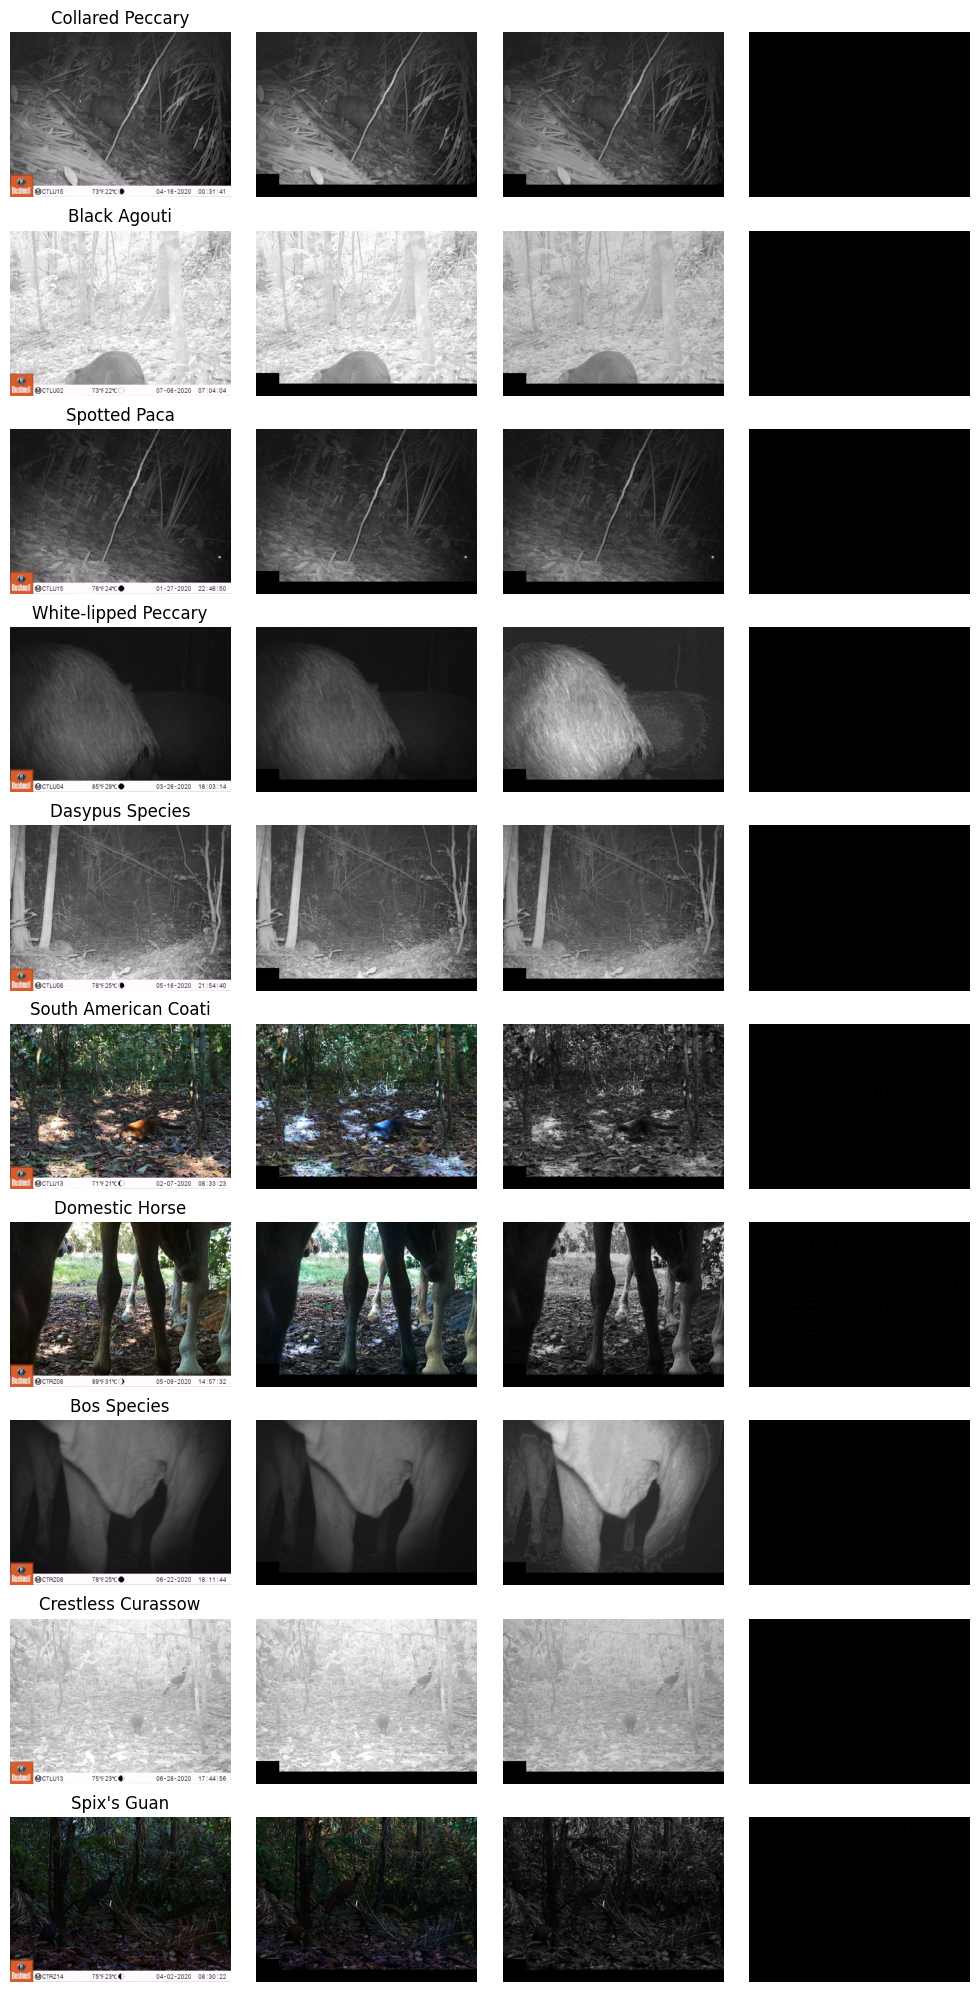

In [ ]:
#visualize
fig, axs = plt.subplots(nrows=len(sample_filenames), ncols=4, figsize=(10, 20), tight_layout=True)

for i in range(len(sample_filenames)):

  img_raw = plt.imread(f"{downsampled_path}/{sample_filenames[i]}")
  img_preprocessed = plt.imread(f"{preprocessed_path}/{sample_filenames[i]}")
  img_red = plt.imread(f"{preprocessed_red_path}/{sample_filenames[i]}")
  img_gray = rgb2gray(img_red)
  features, h = hog(img_gray, orientations=8, pixels_per_cell=(50, 50), visualize=True)

  axs[i, 0].imshow(img_raw)
  axs[i, 0].set_title(species_list[i])
  axs[i, 0].axis("off")

  axs[i, 1].imshow(img_preprocessed)
  axs[i, 1].axis("off")

  axs[i, 2].imshow(img_gray, cmap='gray')
  axs[i, 2].axis("off")

  axs[i, 3].imshow(h*10, cmap='gray', vmin=0, vmax=0.5)
  axs[i, 3].axis("off")

plt.show()

In [ ]:
np.count_nonzero(h)

342684